In [19]:
import jax
import jax.numpy as jnp
from ripplegw.constants import gt, m_per_Mpc, PI, TWO_PI, MRSUN, C
from ripplegw.waveforms.IMRPhenomXAS import gen_IMRPhenomXAS_hphc
from ripplegw import ms_to_Mc_eta, lambdas_to_lambda_tildes, get_eff_pads, get_match_arr

import lalsimulation as lalsim
import lal
import numpy as np

import matplotlib.pyplot as plt

In [20]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

In [21]:
m1 = 2 # In solar masses
m2 = 2
chi1 = 0.141 # Dimensionless spin
chi2 = 0.141
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle

q = m1/m2
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

theta_ripple = jnp.array(
    [
        Mc,
        eta,
        chi1,
        chi2,
        dist_mpc,
        tc,
        phic,
        inclination,
    ]
)
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

In [22]:
# Generate ripple plus strain
hp_ripple, _ = gen_IMRPhenomXAS_hphc(fs_ripple, theta_ripple, f_ref)

In [23]:
# Set up LAL parameters

laldict = lal.CreateDict()

IMRphenom = "IMRPhenomXAS"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

theta = np.array(
    [m1, m2, chi1, chi2, dist_mpc, tc, phic, inclination]
)

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

# Generate LAL plus strain
hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)

freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]
hp_LAL = hp.data.data[mask_lal]
f = freqs_lal[mask_lal]

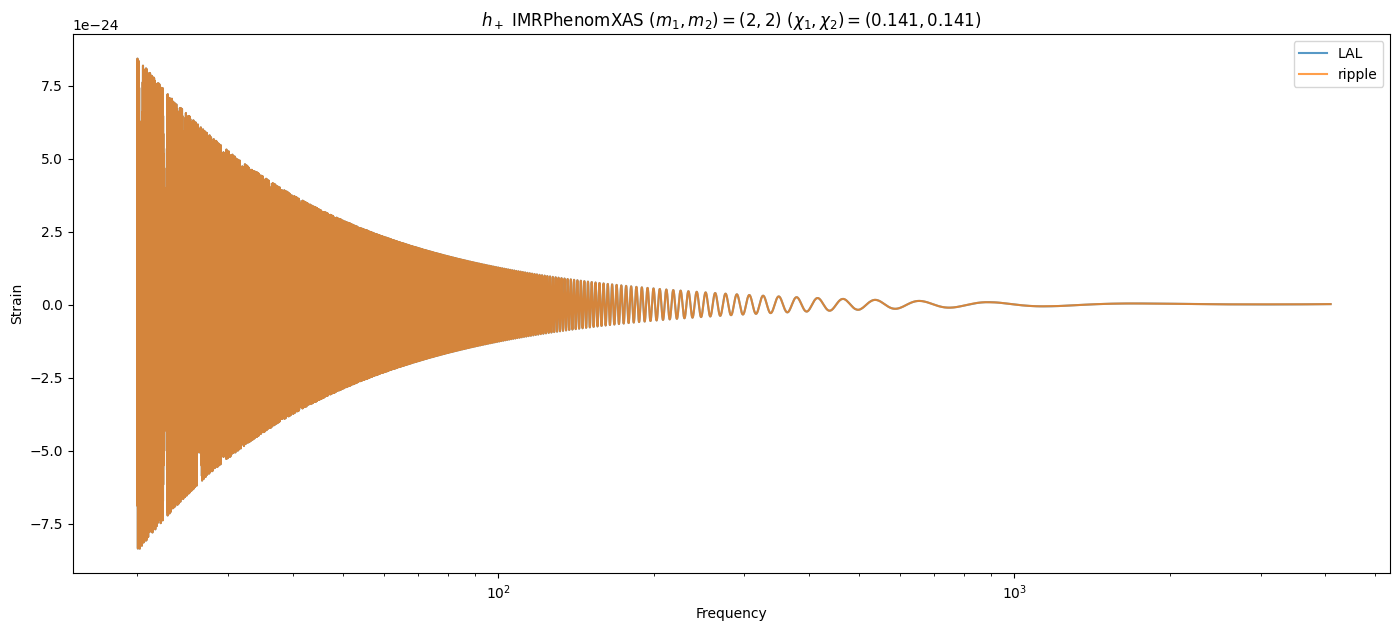

In [24]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_LAL.real, "-", label="LAL", alpha=a)
plt.plot(f, hp_ripple.real, "-", label="ripple", alpha=a)
plt.title(
    r"$h_+$ IMRPhenomXAS ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$)".format(m1,m2,chi1,chi2)
)
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale("log")
plt.xlim(f_l - 5)
plt.legend()
plt.show()

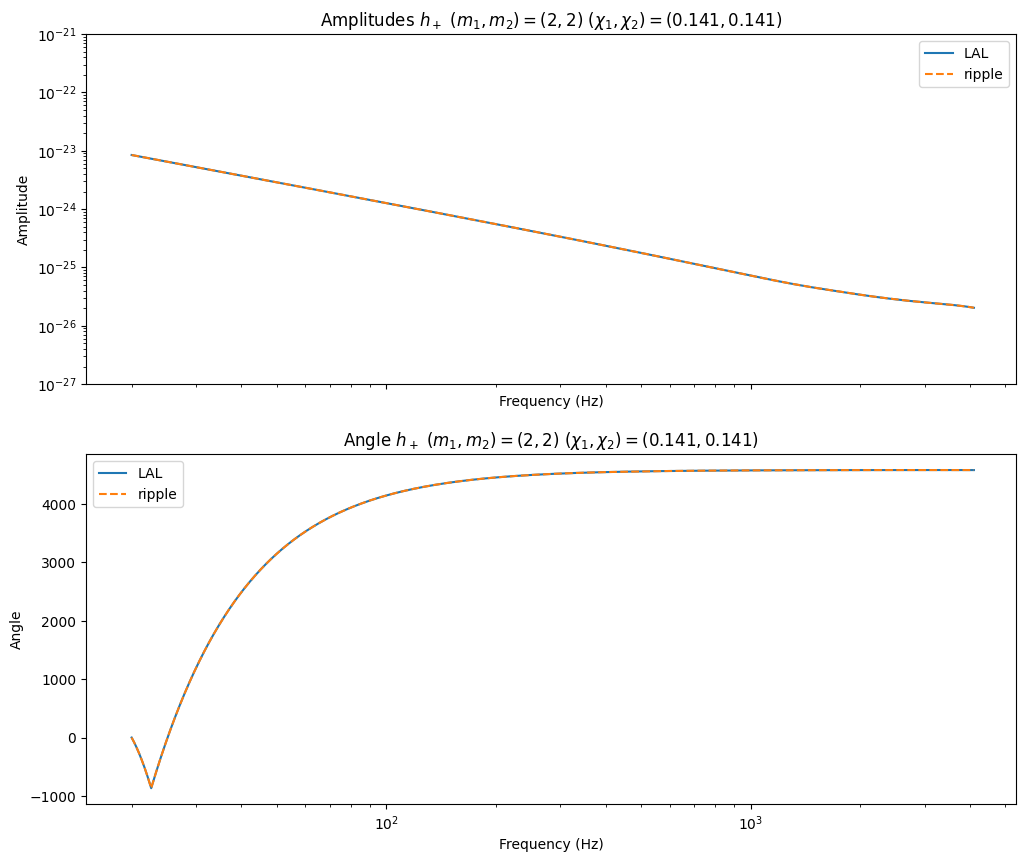

In [25]:
## Get the merger frequency to check the Planck taper window

merger_params = jnp.array([m1, m2, chi1, chi2])

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label="LAL")
plt.plot(fs_ripple, A_ripple, "--", label="ripple")

plt.title(
    r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2
    )
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label="LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label="ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], phase_lalsuite, "-", label="LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label="ripple")
    name = "Phase"
plt.legend()
plt.title(
    r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
plt.xlim(f_l - 5)
plt.show()

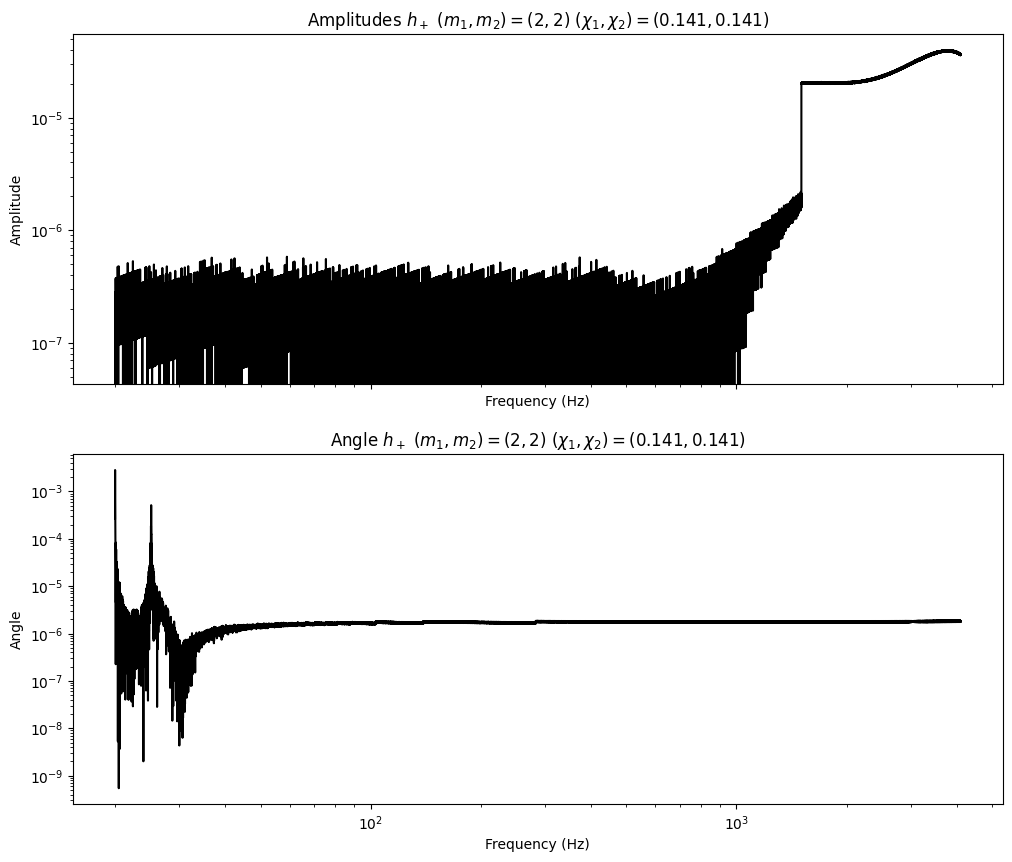

In [26]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple) / A_lalsuite
plt.plot(f, diffs_amplitude, "-", color="black")

plt.title(
    r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2
    )
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs((angle_lalsuite - angle_ripple)/angle_lalsuite), "-", color="black")
name = "Angle"
# plt.legend()
plt.title(
    r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
plt.yscale("log")
plt.show()